In [1]:
%matplotlib notebook
from random import randint, uniform, seed
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from instrumentation import *
from hpca_config import *
work_dir = params['working_dir']
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
#------------------------INITIALIZTION-----------------------
econ = initialize() # initialize pyramidal CA1 neuron from Poirazi 2003
#ad = select_section(eval(params['Simulation']['section'].value))
ad = eval(params['Simulation']['section'].value)
ad.uninsert('mykca')
ad.uninsert('kca')
ad.uninsert('cad')
ad.insert('hpca2')
ad.uninsert('calH')
ad.insert('cal')

for seg in ad:
    seg.cal.gcalbar = params['CaL']['gcalbar_dendrite'].value
    seg.cat.gcatbar = params['CaT']['gcatbar_dendrite'].value

h.TotalHPCA_hpca2 = params['HPCA']['HPCA0'].value
h.k7HPCA_hpca2 = params['HPCA']['k7HPCA'].value
h.TotalPump_hpca2 = params['HPCA']['Pump0'].value
h.Bufer0_hpca2 = params['HPCA']['Buffer0'].value
h.k1bufer_hpca2 = params['HPCA']['k1B'].value
h.k2bufer_hpca2 = params['HPCA']['k2B'].value
h.k1Pump_hpca2 = params['HPCA']['k1P'].value
h.k2Pump_hpca2 = params['HPCA']['k2P'].value
h.cai0_hpca2 = params['HPCA']['Ca_i'].value
h.tau_d_hpca2 = params['HPCA']['tau_d'].value
ad.diam = params['Neuron']['diam'].value
ad.L = params['Neuron']['length'].value

	1 
	1 
	1 
	1 
	1 
	1 
object ExperimentControl created.

	1 
	1 
	1 
	0 
xopen("../lib/vector-distance.hoc")
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
Opened. Setting up the cell 

xopen("../lib/cut-sections.hoc")
	1 
xopen("../lib/map-segments-to-3d.hoc")
	1 
xopen("../lib/current-balance.hoc")
	1 
Balancing each compartment to -70 mV


In [2]:
a = [i for i in h.allsec() if 'apical' in str(i)]
print(a)

[apical_dendrite[0], apical_dendrite[1], apical_dendrite[2], apical_dendrite[3], apical_dendrite[4], apical_dendrite[5], apical_dendrite[6], apical_dendrite[7], apical_dendrite[8], apical_dendrite[9], apical_dendrite[10], apical_dendrite[11], apical_dendrite[12], apical_dendrite[13], apical_dendrite[14], apical_dendrite[15], apical_dendrite[16], apical_dendrite[17], apical_dendrite[18], apical_dendrite[19], apical_dendrite[20], apical_dendrite[21], apical_dendrite[22], apical_dendrite[23], apical_dendrite[24], apical_dendrite[25], apical_dendrite[26], apical_dendrite[27], apical_dendrite[28], apical_dendrite[29], apical_dendrite[30], apical_dendrite[31], apical_dendrite[32], apical_dendrite[33], apical_dendrite[34], apical_dendrite[35], apical_dendrite[36], apical_dendrite[37], apical_dendrite[38], apical_dendrite[39], apical_dendrite[40], apical_dendrite[41], apical_dendrite[42], apical_dendrite[43], apical_dendrite[44], apical_dendrite[45], apical_dendrite[46], apical_dendrite[47], a

In [91]:
class Synapse:

    num_synapses = 0
    gmax_AMPA = 0.001 * 100
    gmax_NMDA = 0.7 * 0.001 * 100

    stimulator = h.VecStim()
    spike_times = list(range(950, 3000, 200))
    spikes_vector = h.Vector(spike_times)


    def __init__(self, loc):
        '''Create AMPA/NMDA synapse at given location ('loc' argument)
        '''
        self.loc = loc # location of the synapse
        #self.spike_times = list(range(500, 1000, 20)) + list(range(4000, 8000, 60))
        self.GluSyn = h.SimpleAMPA_NMDA(self.loc)
        self.GluSyn.gmax_AMPA = Synapse.gmax_AMPA
        self.GluSyn.gmax_NMDA = Synapse.gmax_NMDA
        Synapse.num_synapses += 1

        self.connection = h.NetCon(Synapse.stimulator, self.GluSyn)
        self.connection.weight[0] = 1

    def __repr__(self):
        return 'Synapse[{}]'.format(self.loc)


    @classmethod
    def setup_gmax(cls, gmax_AMPA_new=0, gmax_NMDA_new=0):
        '''updates AMPA and NMDA coductances
        '''
        Synapse.gmax_AMPA = gmax_AMPA_new
        Synapse.gmax_NMDA = gmax_NMDA_new


    @classmethod
    def play_stimulation(cls):
        '''Presynaptic stimulation of all Synapse instances
        '''
        cls.stimulator.play(cls.spikes_vector)


    @classmethod
    def restore_defaults(cls):
        '''restores default conductances and synapse counter (num_synapses)
        '''
        Synapse.gmax_AMPA = 0.001 * 100
        Synapse.gmax_NMDA = 0.7 * 0.001 * 100


    @classmethod
    def create_synapses(cls, locs=None, num_rand_locs=None) -> 'synapses instances':
        '''Method for creating  synapses at given locations
        '''
        Synapse.restore_defaults()
        if locs:
            Synapse.setup_gmax(gmax_AMPA_new = Synapse.gmax_AMPA / len(locs),
                               gmax_NMDA_new = Synapse.gmax_NMDA / len(locs))
            syns = [cls(h.apical_dendrite[loc](0.5)) for loc in locs]
            return syns
        if num_rand_locs:
            seed(666)
            if num_rand_locs > 300:
                raise ValueError('No more than 300 synapses are allowed. %s were given' % num_rand_locs)
            # changes NMDA and AMPA coductances proportionally to num_rand_locs
            # to satisfy constant total coductance for any no. of synapses
            Synapse.setup_gmax(gmax_AMPA_new = Synapse.gmax_AMPA / num_rand_locs,
                               gmax_NMDA_new = Synapse.gmax_NMDA / num_rand_locs)
            syns = [cls(h.apical_dendrite[randint(0, 118)](uniform(0, 1))) for i in range(num_rand_locs)]
            return syns


In [92]:
synapses = Synapse.create_synapses(num_rand_locs=20)
Synapse.play_stimulation()
print(Synapse.gmax_AMPA)  

0.005


In [93]:
print(ad.psection()['density_mechs'].keys())
train_stim = trains_stim( h.soma[1](.5), per=20, delay=200,  n=params['Simulation']['#spikes'].value,
        amp=1.2, dur=10)
train_stim.num = 25
ipulses = h.Vector().record(train_stim._ref_i)

dict_keys(['pas', 'cal', 'car', 'cat', 'd3', 'hha_old', 'h', 'hpca2', 'kad', 'kap', 'km'])


In [94]:
t = h.Vector().record(h._ref_t)
ica = h.Vector().record(ad(.5)._ref_ica)
ica_pmp = h.Vector().record(ad(0.5)._ref_ica_pmp_hpca2)
cai = h.Vector().record(ad(0.5)._ref_cai)
hpca = h.Vector().record(ad(0.5)._ref_HPCA_m_z_hpca2)
tot_hpca = h.Vector().record(ad(.5)._ref_HPCA_tot_z_hpca2)
ik_sahp = h.Vector().record(ad(.5)._ref_ik_hpca2)
v = h.Vector().record(ad(.5)._ref_v)

In [99]:
ad(.5).area()
del train_stim

<IPython.core.display.Javascript object>


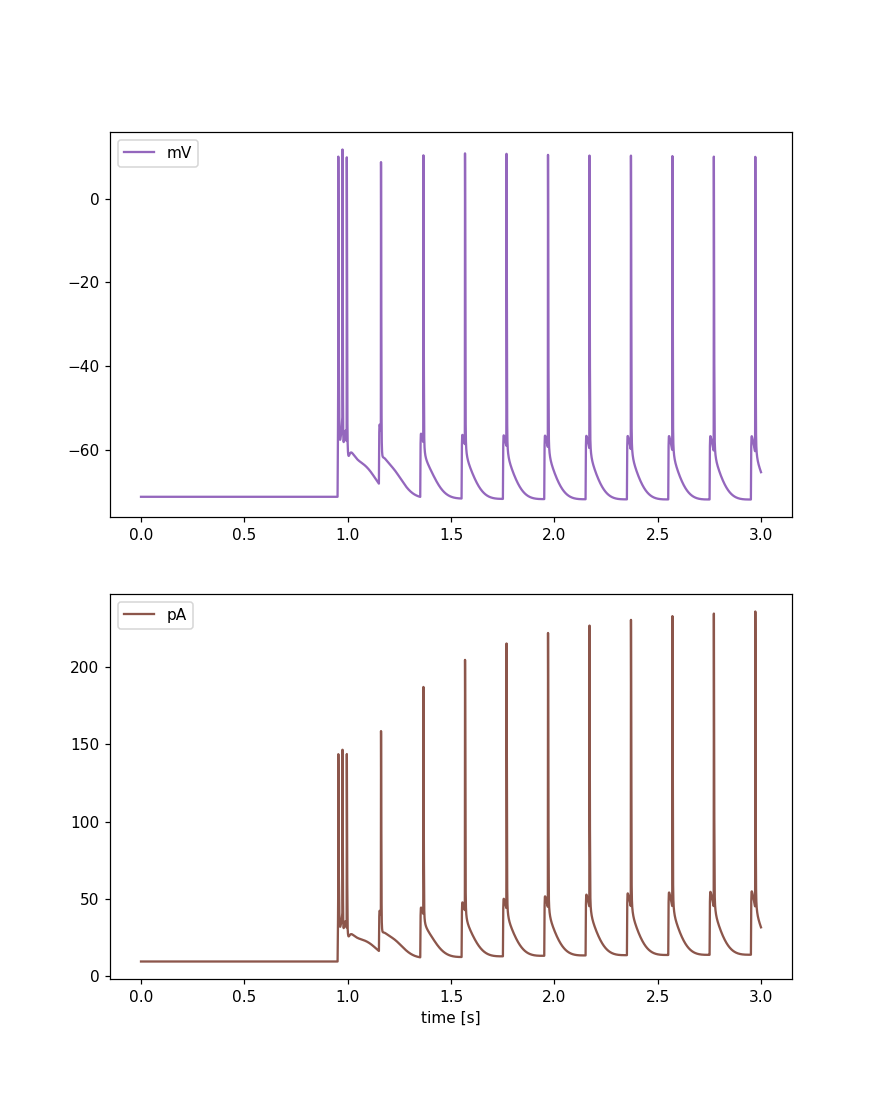

In [103]:
h.TotalHPCA_hpca2 = 0.08
run(dur=3000)

n_spikes = str(params['Simulation']['#spikes'].value)
diameter = str(params['Neuron']['diam'].value)
fig, axs = hpca_plot(t,
        (v, 'mV'),
        #(cai*10**6, 'Cai (nM)'),
        #(hpca/tot_hpca, 'HPCAm/HPCAtot'),
        (ik_sahp*10*ad(.5).area(), 'pA'),
        #title= '%s current pulses, f = 25 Hz, amp=10 nA, dur=15 ms, diam = %s um' % (n_spikes, diameter),
                    )

#fig.savefig(work_dir + params['filename'])